In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import string 
import random
import re
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense
# nltk.download('stopwords')
# nltk.download('wordnet')

In [4]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

df = pd.read_csv('G:/771768/A_AI/assignment/imdb.csv')
# df = df.head(5000)
df = df.sample(n=10000, random_state=1)
df['review'] = df['review'].astype(str)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove null values
df.dropna(inplace=True)

# Convert to lowercase
df['review'] = df['review'].str.lower()

# Function to remove HTML Tags
def remove_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',text)

df['review'] = df['review'].apply(remove_tags)

# Function to remove URLs
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

df['review'] = df['review'].apply(remove_url)

# Remove Punctuations
exclude = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

df['review'] = df['review'].apply(remove_punc)

# ChatWords dictionary
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

df['review'] = df['review'].apply(chat_conversion)

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

df['review'] = df['review'].apply(remove_stopwords)

# Load the English language model
nlp = spacy.load('en_core_web_sm')


In [5]:
# Create a list to store tokens for each review
all_tokens = []

# Process each review in the DataFrame
for review in df['review']:
    doc = nlp(review)
    # Create a list to store tokens for this review
    review_tokens = []
    # Iterate through each token in the processed review
    for token in doc:
        review_tokens.append(token.text)
    # Append the tokens for this review to the list of all tokens
    all_tokens.append(review_tokens)
    
# Print the tokens for the first review
print(all_tokens[0])

ps = PorterStemmer()

def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

df['review'] = df['review'].apply(stem_words)




['dead', 'heroes', 'get', 'stupid', 'lines', 'like', 'woefully', 'abysmal', 'action', 'flick', 'needs', 'seen', 'believed', 'william', 'sanders', 'saved', 'buddy', 'harry', 'cotter', 'extraction', 'vietnam', 'gets', 'captured', 'enemy', 'fast', 'forward', 'ten', 'years', 'harry', 'brainwashed', 'russian', 'operative', 'mind', 'control', 'microchip', 'implanted', 'brain', 'new', 'russian', 'superior', 'ivan', 'played', 'obscene', 'hilt', 'nick', 'nicholson', 'might', 'add', 'does', 'nt', 'attempt', 'speak', 'russian', 'accent', 'resembles', 'gas', 'station', 'attendant', 'kentucky', 'stained', 'teeth', 'even', 'absurd', 'fact', 'also', 'dialog', 'coach', 'film', 'soon', 'william', 'rerecruited', 'cia', 'hunt', 'harry', 'teams', 'barbara', 'freedom', 'fighter', 'infiltrated', 'ivans', 'el', 'salvador', 'camp', 'soon', 'blowing', 'half', 'south', 'america', 'scenes', 'jaw', 'droppingly', 'awful', 'wonder', 'film', 'does', 'nt', 'cult', 'following', 'one', 'scene', 'sudden', 'lovemaking', 

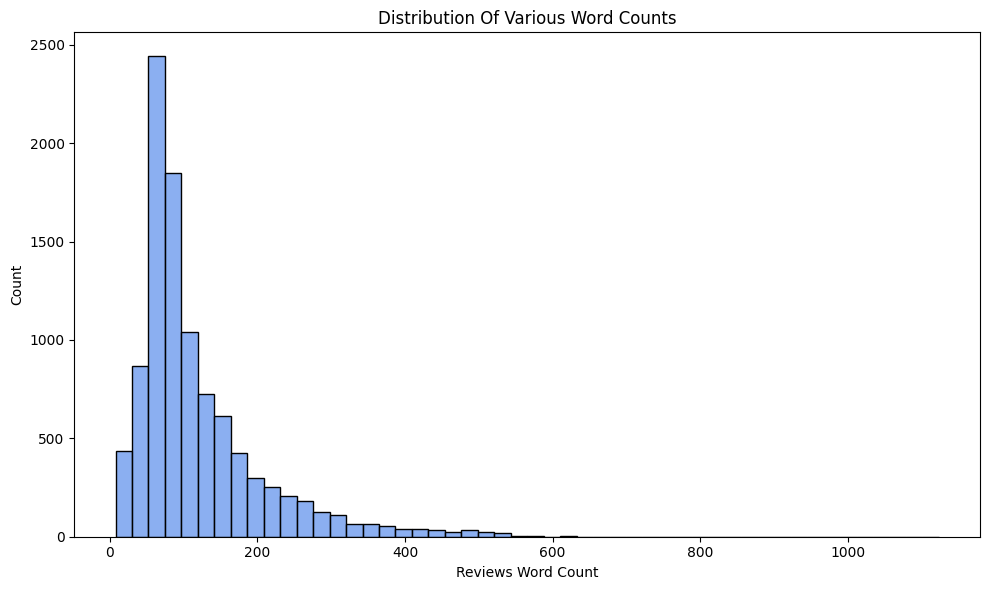

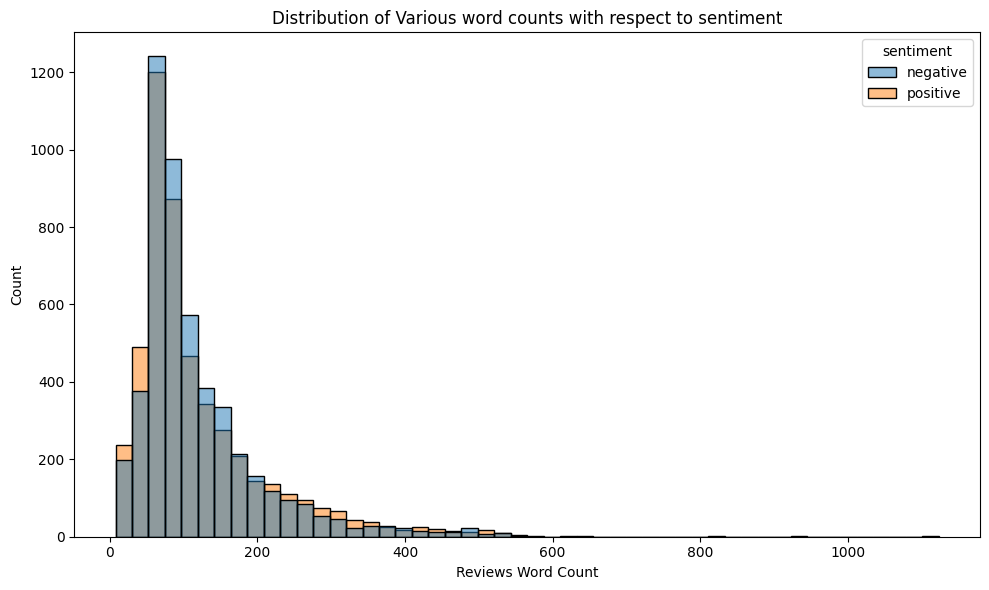

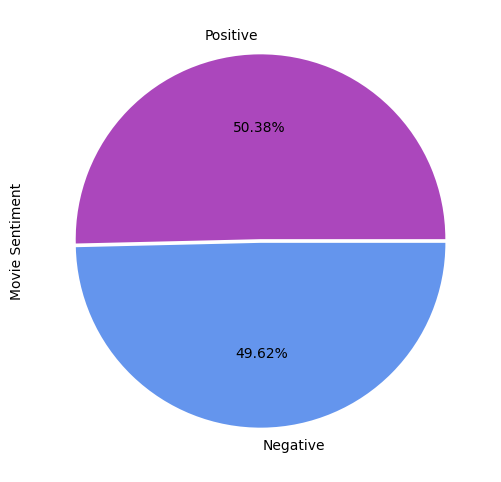

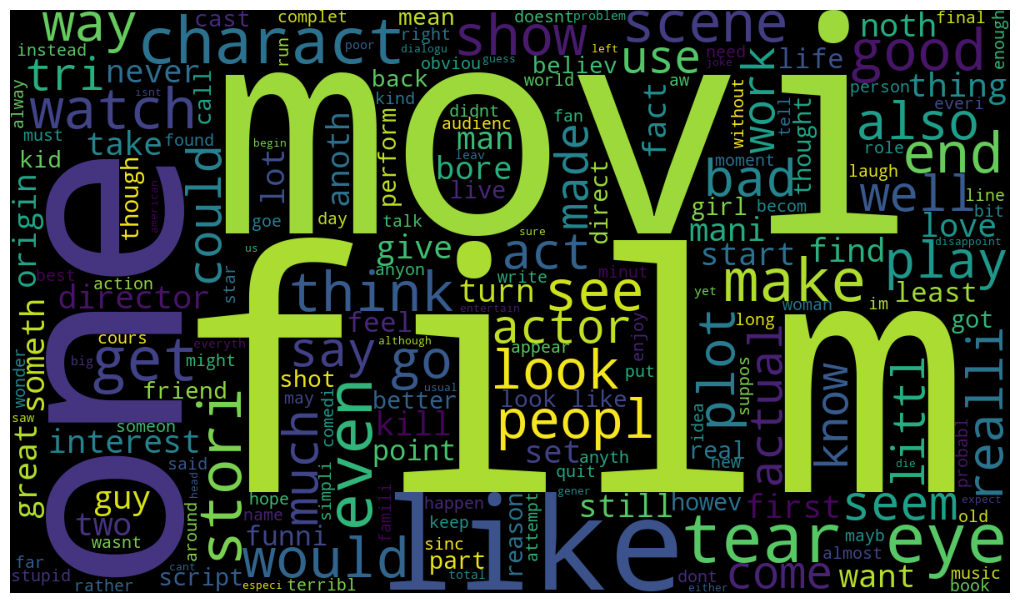

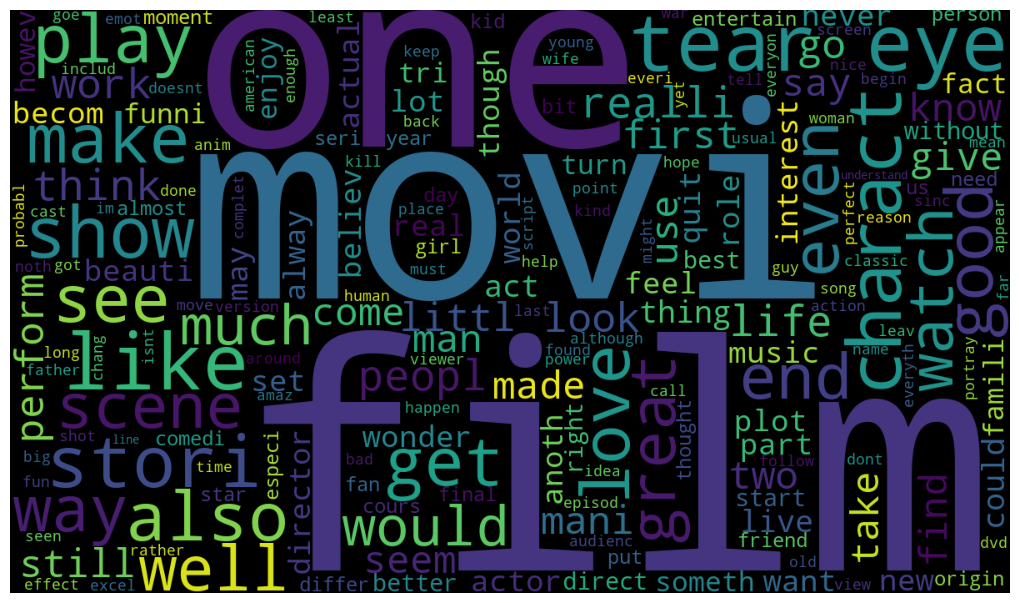

watch gristl primarili presenc michael dorn enjoy worf portray star trek tng never seen makeup dorn appear nice presenc probabl potenti profit act career movi howev gave littl dramat challeng except prove inde use f wordit appear movi made someon fanci forwardthink type social conscienc yeah 1965 today theme belabor sophomor cornbal even spike lee dread bamboozl look good comparisonthi crimecap flick intric labrynth doubl tripl quadruplecross plot scheme convolut collaps upon within first 30 minut mostli point simpli watch momentum mild curios scene would play great cast recogn virtual everyon charact actor much better movi suspect 1 work money even modest 2 perhap director know actor act class social connect around la know perhap particip support fellow struggl movi guy third fourth tier hollywood scene dunno movi halfbak realli finish gave 3 although affect actor involv undiminish admir previou work let hope everybodi move profession care done thorough project sinc

Negative



film 

In [12]:
# Feature Engineering
df['review_word_count'] = df['review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='review_word_count', bins=50, color='#6495ED')
plt.title("Distribution Of Various Word Counts")
plt.xlabel("Reviews Word Count")
plt.tight_layout()
plt.savefig('1.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='review_word_count', hue='sentiment', bins=50)
plt.title("Distribution of Various word counts with respect to sentiment")
plt.xlabel("Reviews Word Count")
plt.tight_layout()
plt.savefig('2.png')
plt.show()

plt.figure(figsize=(10,6))
colors=['#AB47BC','#6495ED']
plt.pie(df['sentiment'].value_counts(), labels=['Positive','Negative'], autopct='%.2f%%', explode=[0.01,0.01], colors=colors)
plt.savefig('3.png')
plt.ylabel('Movie Sentiment')

# Negative Word Cloud
text_list_n = " ".join(df.loc[df['sentiment']=='negative', 'review'])
wordcloud = WordCloud(width=1200, height=700, background_color='black', stopwords=stop_words, min_font_size=10).generate(text_list_n)
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('4.png')
plt.show()

# Positive Word Cloud
text_list_p = " ".join(df.loc[df['sentiment']=='positive', 'review'])
wordcloud = WordCloud(width=1200, height=700, background_color='black', stopwords=stop_words, min_font_size=10).generate(text_list_p)
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('5.png')
plt.show()

random_index = random.randint(0, df.shape[0]-6)
for row in df[['review', 'sentiment']][random_index:random_index+5].itertuples():
    _, review, sentiment = row
    class_name = "Positive" if sentiment == 'positive' else "Negative"
    print(f"{review}\n")
    print(f"{class_name}\n\n\n")

Accuracy: 85.03%

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      1036
    positive       0.86      0.83      0.84       961

    accuracy                           0.85      1997
   macro avg       0.85      0.85      0.85      1997
weighted avg       0.85      0.85      0.85      1997



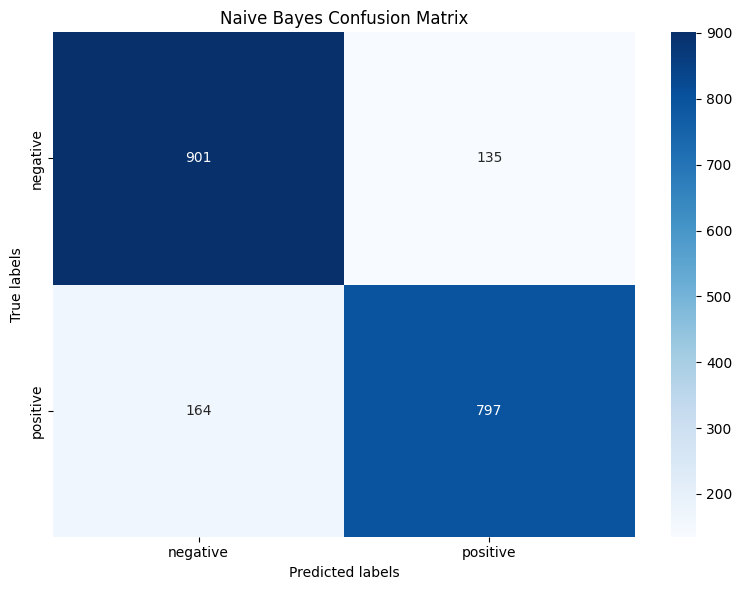

In [13]:
X = df['review']
y = df['sentiment']

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Fit the Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Predictions
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluation
accuracy_nb = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy_nb * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=nb_classifier.classes_, columns=nb_classifier.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues")
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()
plt.savefig('6.png')
plt.show()

In [10]:
X = df['review']
y = df['sentiment']

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_tfidf)

# Evaluation
print("K-Means Clustering Results:\n")
print("Silhouette Score:", silhouette_score(X_train_tfidf, kmeans.labels_))
print("Davies-Bouldin Score:", davies_bouldin_score(X_train_tfidf.toarray(), kmeans.labels_))


C:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Clustering Results:

Silhouette Score: 0.0018297560059794865
Davies-Bouldin Score: 14.216908318253706


In [11]:
# Defining X and y
X = df['review']
y = df['sentiment']

# Convert the sentiment labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Padding sequences
maxlen = 100  # Adjust the sequence length as needed
X_padded = pad_sequences(X_sequences, maxlen=maxlen)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Model architecture
embedding_dim = 100  # Adjust the embedding dimension as needed
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen),
    SimpleRNN(units=64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
print(model.summary())

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy_rnn = model.evaluate(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(accuracy_rnn * 100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1014785 (3.87 MB)
Trainable params: 1014785 (3.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
225/225 [==============================] - 6s 21ms/step - loss: 0.5587 - accuracy: 0.6866 - val_loss: 0.3579 - val_accuracy: 0.8498
Ep

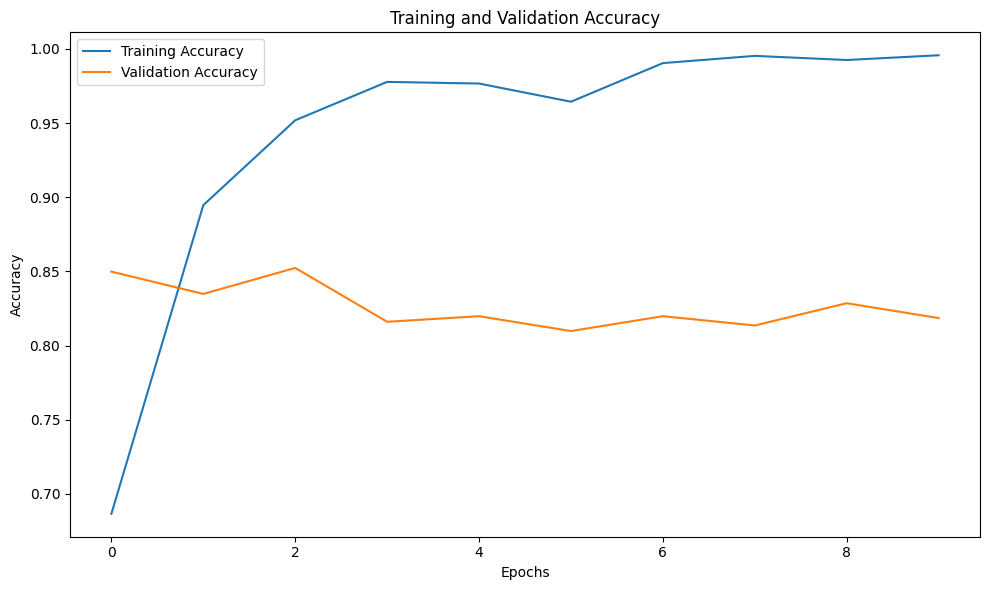

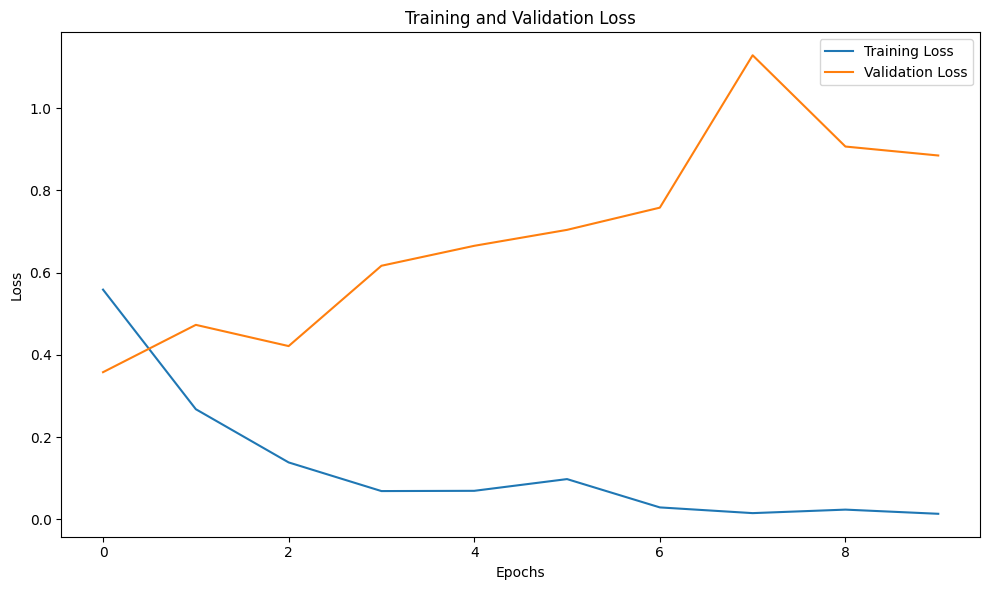

In [14]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('7.png')
plt.show()
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('8.png')
plt.show()

In [15]:
# Defining X and y
X = df['review']
y = df['sentiment']

# Convert the sentiment labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Padding sequences
maxlen = 100  # Adjust the sequence length as needed
X_padded = pad_sequences(X_sequences, maxlen=maxlen)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Model architecture
embedding_dim = 100  # Adjust the embedding dimension as needed
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen),
    LSTM(units=64, activation='relu'),
     Dense(64, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
print(model.summary())

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy_lstm = model.evaluate(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(accuracy_lstm * 100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1046465 (3.99 MB)
Trainable params: 1046465 (3.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
225/225 [==============================] - 12s 46ms/step - loss: 0.6599 - accuracy: 0.6249 - val_loss: 0.4967 - val_accuracy: 0.7472

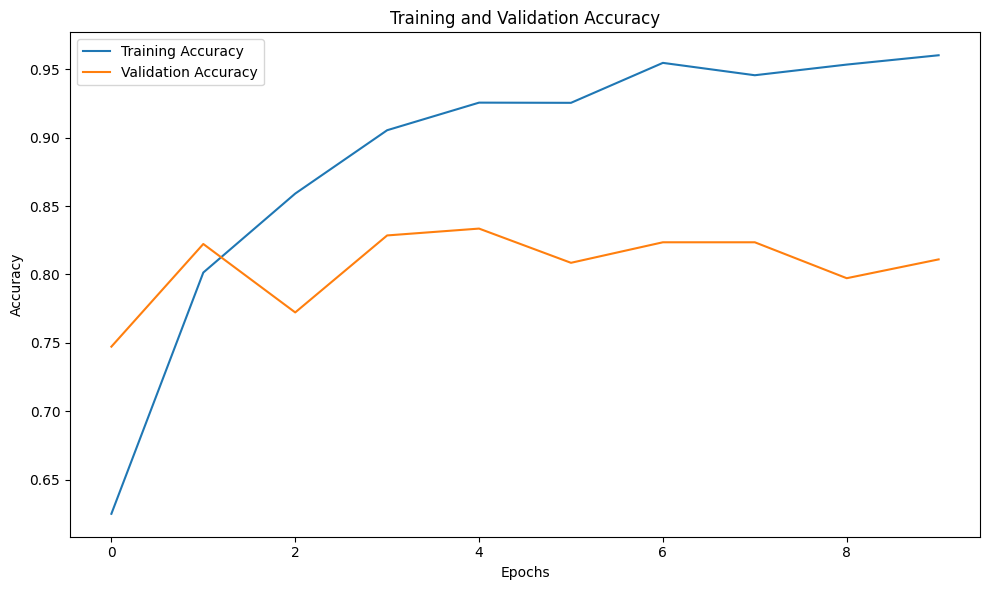

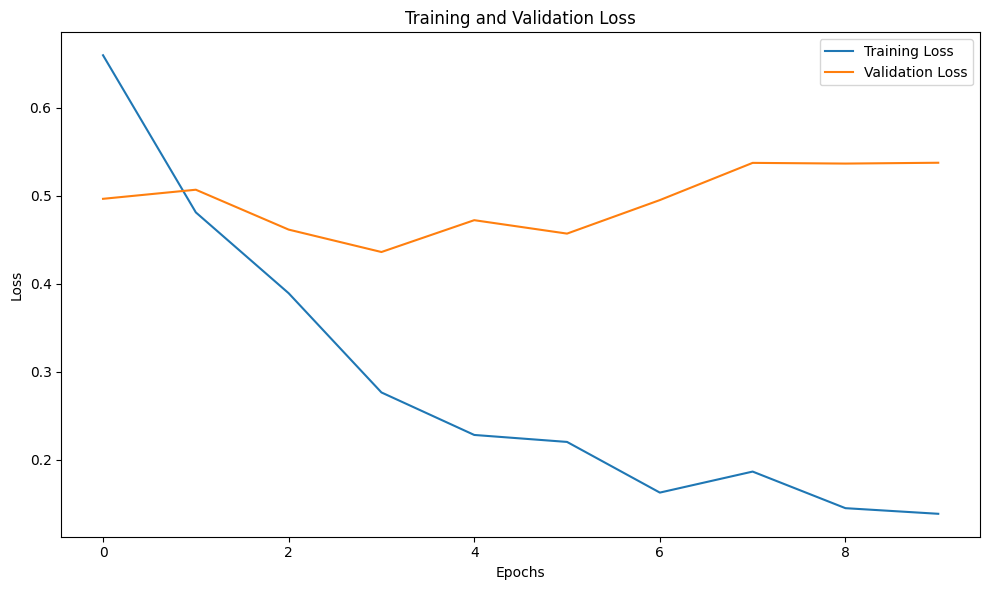

In [16]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('9.png')
plt.show()
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('10.png')
plt.show()

<Figure size 1000x600 with 0 Axes>

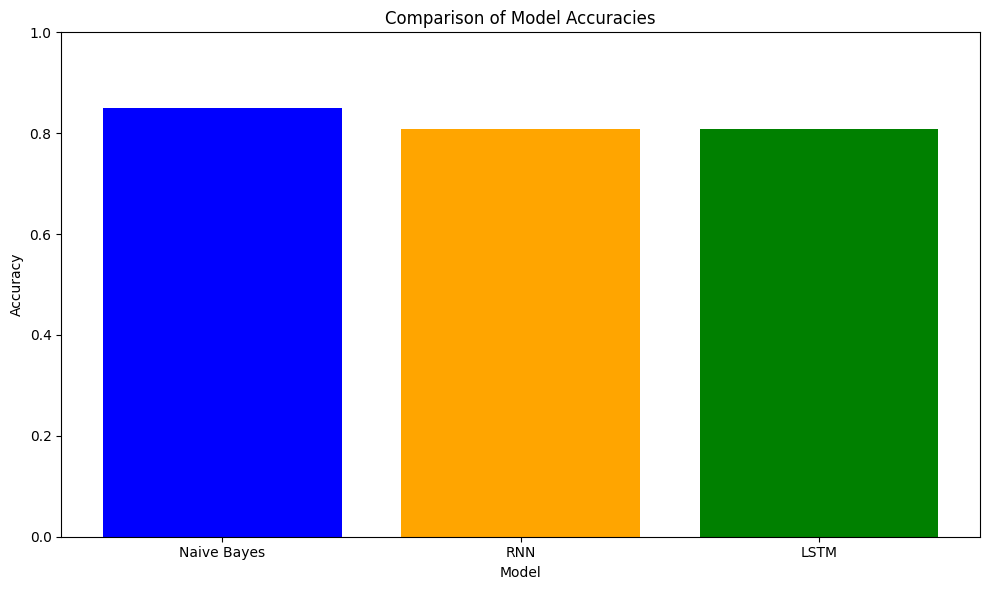

In [17]:
# Plotting comparison
plt.figure(figsize=(10, 6))
models = ['Naive Bayes', 'RNN', 'LSTM']
accuracies = [accuracy_nb, accuracy_rnn, accuracy_lstm]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('11.png')
plt.show()